# Resolution of the optimisation problem

This notebook will help solve the following optimisation problem : 
TODO

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT =", PROJECT_ROOT)


PROJECT_ROOT = c:\Users\Nicolas\Desktop\ECOLE\3A\Projet Avencore\avencore_hydrogen_production-Marie


## 1. Imports initiaux

In [2]:
import pyomo.environ as pyo

from Data.loading import load_prices
from Battery.battery_simulation import BatteryParams, BatteryBlock
from Electrolyser.electrolyser_simulation import ElectrolyserParams, ElectrolyserBlock, PowerBalanceBlock
from Costs.cost_functions import EconomicParams, ObjectiveBuilder

## 2. Loading the dataset

In [3]:
PATH_SPOT = "../Data/prix_spot.csv"
ELEC_PRICE, CO2_INTENSITY, T, df_2024 = load_prices(PATH_SPOT, year=2024)

## 3. Global parameters

In [4]:
dt = 1.0
ECON_PARA = EconomicParams(
    CAPEX_PWR_BAT = 150.0,
    CAPEX_EN_BAT = 10_000.0,
    FORWARD_PRICE = 75.0,
    CO2_COST = 80.0
)

ELECTRO_PARA = ElectrolyserParams(
    PWR_H2_MAX = 100.0,
    U_ELECTRO_MIN = 0.10,
    U_ELECTRO_MAX = 0.95,
    RAMP_ELECTRO = 1.0,
    ELECTRO_YIELD = 0.70,
    LHV_H2 = 55.0,
    dt = dt,
    H2_TARGET = 1_000_000.0
)

BAT_PARA = BatteryParams(
    CHARGE_YIELD = 1.0,
    DISCHARGE_YIELD = 1.0,
    dt = dt,
    SOC_MIN = 0.10,
    SOC_MAX = 0.95
)

## 4. Pyomo model definition

In [5]:
m = pyo.ConcreteModel()
m.T = pyo.RangeSet(0, T-1)

# Dimension variables
m.PWR_BAT_MAX = pyo.Var(domain=pyo.NonNegativeReals) # MW
m.EN_BAT_MAX = pyo.Var(domain=pyo.NonNegativeReals) # MWh

## 5. Adding the different blocs

In [6]:
# Battery
bat = BatteryBlock(m, m.T, BAT_PARA)
bat.add_variables()
bat.add_constraints()

# PEM Electrolyser
el = ElectrolyserBlock(m, m.T, ELECTRO_PARA)
el.add_variables()
el.add_constraints()

# Power balance
pb = PowerBalanceBlock(m, m.T, PWR_H2_MAX=ELECTRO_PARA.PWR_H2_MAX, PHI_BOUNDS=(0.0,1.0))
pb.add_variables()
pb.add_constraints()

## 6. Objective definition and solving

In [7]:
objb = ObjectiveBuilder(m, m.T, ECON_PARA, ELEC_PRICE=ELEC_PRICE, CO2_INTENSITY=CO2_INTENSITY, dt=dt, include_co2=False)
objb.build_objective()

solver = pyo.SolverFactory("appsi_highs")
res = solver.solve(m, tee=True)
print(res.solver.status, res.solver.termination_condition)

Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 87840 rows; 52707 cols; 210812 nonzeros
Coefficient ranges:
  Matrix  [1e-01, 1e+02]
  Cost    [1e-02, 7e+05]
  Bound   [1e+00, 1e+00]
  RHS     [1e+00, 1e+06]
Presolving model
61486 rows, 43922 cols, 166890 nonzeros  0s
Dependent equations search running on 12399 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
56316 rows, 38754 cols, 181706 nonzeros  0s
Presolve reductions: rows 56316(-31524); columns 38754(-13953); nonzeros 181706(-29106) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0071233131e+02 Ph1: 361(4166); Du: 361(100.712) 0s
      22596     7.1163591377e+03 Pr: 0(0); Du: 378(103.564) 6s
      25833     6.4537102586e+03 Pr: 0(0) 11s
      25833     6.4537102586e+03 Pr: 0(0) 11s

Performed postsolve
Solving the or

## 7. Results

In [8]:
MEAN_H2_PWR = sum(pyo.value(m.PWR_H2[t]) for t in m.T) / T
TOT_H2_PWR = sum(pyo.value(m.PWR_H2[t]) for t in m.T)
H2_TOT_PROD  = sum(pyo.value(m.H2[t]) for t in m.T)
COST_OPTI = pyo.value(m.Obj)
MEAN_COST = (sum(ECON_PARA.FORWARD_PRICE * pyo.value(m.PHI) * dt + ELEC_PRICE[t] * pyo.value(m.PWR_SPOT[t]) * dt for t in m.T) / max(TOT_H2_PWR, 1e-9))
LCOH_OPTI = COST_OPTI / max(H2_TOT_PROD, 1e-9)

print("Electrolyser max power (MW):", f"{ELECTRO_PARA.PWR_H2_MAX:.2f}")
print("Optimal battery power (MW):", f"{pyo.value(m.PWR_BAT_MAX):.2f}")
print("Optimal battery capacity (MWh):", f"{pyo.value(m.EN_BAT_MAX):.2f}")
print("Optimal percentage forward (%):", f"{pyo.value(m.PHI)*100:.2f}")
print("Mean power electrolyser (MW):", f"{MEAN_H2_PWR:.2f}")
print("Total H2 production (kg):", f"{H2_TOT_PROD:.2f}")
print("Total cost (€):", f"{COST_OPTI:.2f}")
print("LCOH (€/kg):", f"{LCOH_OPTI:.2f}")

Electrolyser max power (MW): 100.00
Optimal battery power (MW): 303.45
Optimal battery capacity (MWh): 357.00
Optimal percentage forward (%): 9.83
Mean power electrolyser (MW): 15.36
Total H2 production (kg): 1716797.65
Total cost (€): 6453.71
LCOH (€/kg): 0.00


## 8. Visualisation

192840   2024-01-01 00:00:00
192841   2024-01-01 01:00:00
192842   2024-01-01 02:00:00
192843   2024-01-01 03:00:00
192844   2024-01-01 04:00:00
192845   2024-01-01 05:00:00
192846   2024-01-01 06:00:00
192847   2024-01-01 07:00:00
192848   2024-01-01 08:00:00
192849   2024-01-01 09:00:00
192850   2024-01-01 10:00:00
192851   2024-01-01 11:00:00
192852   2024-01-01 12:00:00
192853   2024-01-01 13:00:00
192854   2024-01-01 14:00:00
192855   2024-01-01 15:00:00
192856   2024-01-01 16:00:00
192857   2024-01-01 17:00:00
192858   2024-01-01 18:00:00
192859   2024-01-01 19:00:00
192860   2024-01-01 20:00:00
192861   2024-01-01 21:00:00
192862   2024-01-01 22:00:00
192863   2024-01-01 23:00:00
192864   2024-01-02 00:00:00
192865   2024-01-02 01:00:00
192866   2024-01-02 02:00:00
192867   2024-01-02 03:00:00
192868   2024-01-02 04:00:00
192869   2024-01-02 05:00:00
192870   2024-01-02 06:00:00
192871   2024-01-02 07:00:00
192872   2024-01-02 08:00:00
192873   2024-01-02 09:00:00
192874   2024-

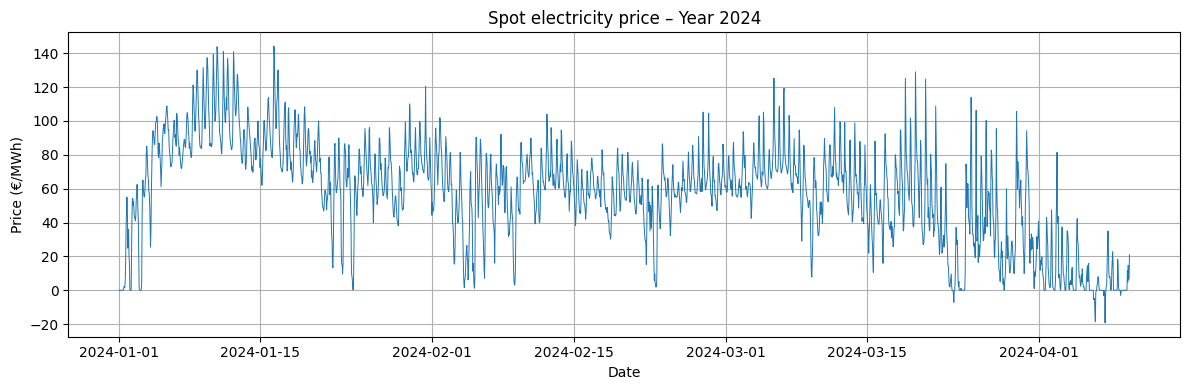

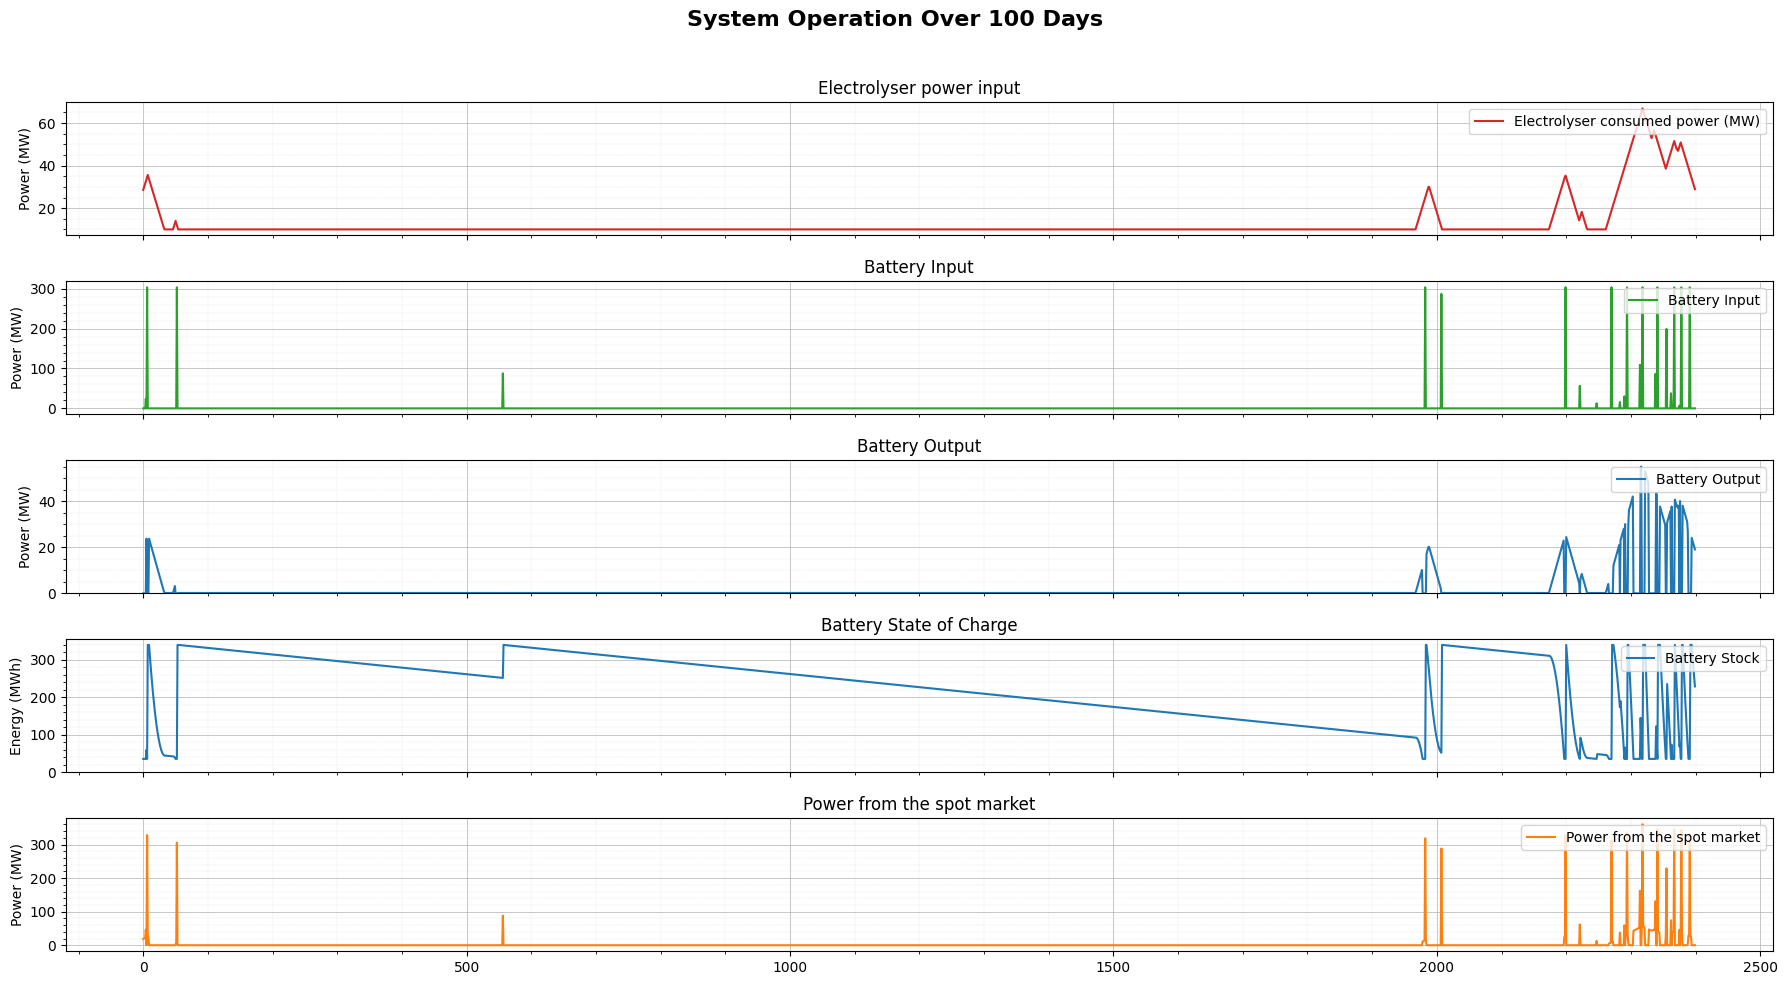

In [ ]:
print(df_2024['Date'][:48])

plt.figure(figsize=(12, 4))
plt.plot(df_2024['Date'][:2400], df_2024['Spot'][:2400], linewidth=0.7)

plt.title("Spot electricity price – Year 2024")
plt.xlabel("Date")
plt.ylabel("Price (€/MWh)")
plt.grid(True)

plt.tight_layout()
plt.show()

num_days = 100
N = num_days * 24

# === Create figure and axes ===
fig, axes = plt.subplots(5, 1, figsize=(18, 10), sharex=True)
fig.suptitle(f"System Operation Over {num_days} Days", fontsize=16, weight='bold')

# Convert the Pyomo Set to a Python list and slice it
time_index = list(m.T)[:N]

# Extract numerical values from Pyomo Variables using pyo.value()
pwr_h2_vals = [pyo.value(m.PWR_H2[t]) for t in time_index]
pwr_charge_vals = [pyo.value(m.PWR_CHARGE[t]) for t in time_index]
pwr_discharge_vals = [pyo.value(m.PWR_DISCHARGE[t]) for t in time_index]
soc_vals = [pyo.value(m.SOC[t]) for t in time_index]
pwr_spot_vals = [pyo.value(m.PWR_SPOT[t]) for t in time_index]

# === Global style for all subplots ===
for ax in axes:
    ax.grid(True, which='major', linestyle='-', linewidth=0.5)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.7)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=10)

# === Plot data ===
axes[0].plot(time_index, pwr_h2_vals, 'tab:red', linewidth=1.5, label='Electrolyser consumed power (MW)')
axes[0].set_ylabel("Power (MW)")
axes[0].legend(loc='upper right')
axes[0].set_title("Electrolyser power input", fontsize=12)

axes[1].plot(time_index, pwr_charge_vals, 'tab:green', linewidth=1.5, label='Battery Input')
axes[1].set_ylabel("Power (MW)")
axes[1].legend(loc='upper right')
axes[1].set_title("Battery Input", fontsize=12)

axes[2].plot(time_index, pwr_discharge_vals, 'tab:blue', linewidth=1.5, label='Battery Output')
axes[2].set_ylabel("Power (MW)")
axes[2].set_ylim(bottom=0)
axes[2].legend(loc='upper right')
axes[2].set_title("Battery Output", fontsize=12)

axes[3].plot(time_index, soc_vals, 'tab:blue', linewidth=1.5, label='Battery Stock')
axes[3].set_ylabel("Energy (MWh)")
axes[3].set_ylim(bottom=0)
axes[3].legend(loc='upper right')
axes[3].set_title("Battery State of Charge", fontsize=12)

axes[4].plot(time_index, pwr_spot_vals, 'tab:orange', linewidth=1.5, label='Power from the spot market')
axes[4].set_ylabel("Power (MW)")
axes[4].legend(loc='upper right')
axes[4].set_title("Power from the spot market", fontsize=12)


# === Final adjustments ===
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()